# Minimal Detectable Deformation and Detectability Power
@author: Max Felius
@date: 17/05/2021

In [1]:
#imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os, sys, time
import re, datetime
from scipy import spatial
from decouple import config

#other
from scipy.stats import norm
import scipy
import tilemapbase
tilemapbase.init(create=True)

#import personal functions
sys.path.extend(os.path.join(os.getcwd(),'sinkhole_functions'))
from sinkhole_functions.functions import *
from sinkhole_functions.geometric_models import *

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authorit

In [2]:
"""
These are the wrong functions to compute the dp and mdd. Your welcome, no significance level.
"""
def solve(m1,m2,std1,std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

def function2(m2,input_var):
    sigma, decpow = input_var
    m1 = 0
#     item = 0.003
    result = solve(m1,m2,sigma,sigma)
    r = result[0]
    return 1-(norm.cdf(r,m2,sigma) + (1-norm.cdf(r,m1,sigma))) - decpow

def linear_model(epochs,data):
    '''
    Function creating the linear model for detect arcs behaving anomalous
    '''
    
    #creating time vector
    delta_days, start_day = get_delta_days(epochs)
    
    #pre-allocate space for the output variables
    a = []
    b = []
    sigma_ehat = []
    
    for i in range(len(data)):
        '''
        Loop creating a linear model per row
        '''
        
        #setting up the system of equations
        y = np.array(data[epochs].iloc[i])
        A = np.array((delta_days,np.ones([len(delta_days)])))
        
        #stochastic matrix
        W = np.eye((len(y)))
        
        #compute solutions
        invW = np.linalg.inv(W)
        Qxhat = np.linalg.inv(A @ invW @ A.T)
        xhat = Qxhat @ A @ invW @ y
        
        yhat = A.T @ xhat
        ehat = y - yhat
        
        #compute the standard deviation of the noise of an arc
        sigma_ehat_out = np.sqrt((np.sum((ehat - np.mean(ehat))**2))/len(y))
        
        #saving the data
        a.append(xhat[0])
        b.append(xhat[1])
        sigma_ehat.append(sigma_ehat_out)
    
    return a, b, sigma_ehat

In [3]:
folder = ''
filename = 't88_points_Franciscanerstraat_r100.csv'
location_file = 'sinkhole_kerkrade.csv'

#load the data
data = pd.read_csv(os.path.join(folder,filename))
# location = pd.read_csv(os.path.join(folder,location_file))

#get information from pandas df
headers = list(data)
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pnt_lon, data.pnt_lat))
data_gdf.crs = 'epsg:4326' #wgs84
# location_gdf = gpd.GeoDataFrame(location, geometry=gpd.points_from_xy(location.longitude, location.latitude))
# location_gdf.crs = 'epsg:4326' #wgs84

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


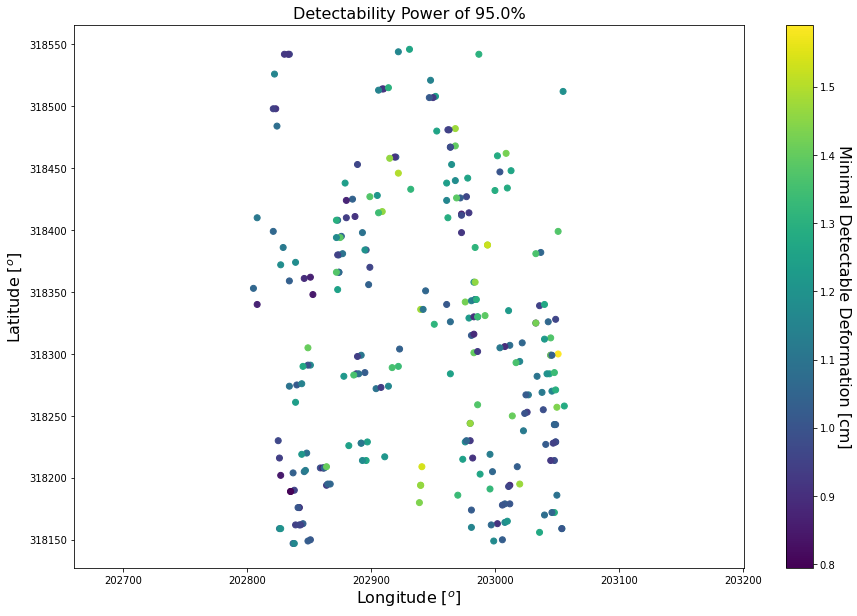

In [4]:
a,b,sigma_lin_model = linear_model(get_sentinel_days(list(data)),data)

MDD = []
decpow = 0.95

for item in sigma_lin_model:
    input_var = [item,decpow]
    MDD.append(100*scipy.optimize.fsolve(function2,item,input_var))

plt.figure(figsize=(15,10))
p = plt.scatter(data['pnt_rdx'],data['pnt_rdy'],c=MDD)
clb = plt.colorbar(p)
clb.set_label("Minimal Detectable Deformation [cm]",rotation=270,labelpad=15,fontsize=16)

plt.title(f'Detectability Power of {decpow*100}%',fontsize=16)
plt.axis('equal')
plt.xlabel('Longitude [$^o$]',fontsize=16)
plt.ylabel('Latitude [$^o$]',fontsize=16);

 Text(0.5168501111111111, 0, '6.0660'),
 Text(0.5168525902777779, 0, '6.0669'),
 Text(0.5168550694444445, 0, '6.0678'),
 Text(0.5168575486111111, 0, '6.0687'),
 Text(0.5168600277777778, 0, '6.0696'),
 Text(0, 0.33541786095209364, '50.8512'),
 Text(0, 0.335421710953711, '50.8521'),
 Text(0, 0.3354255609553284, '50.8529'),
 Text(0, 0.33542941095694573, '50.8538'),
 Text(0, 0.3354332609585631, '50.8547')]

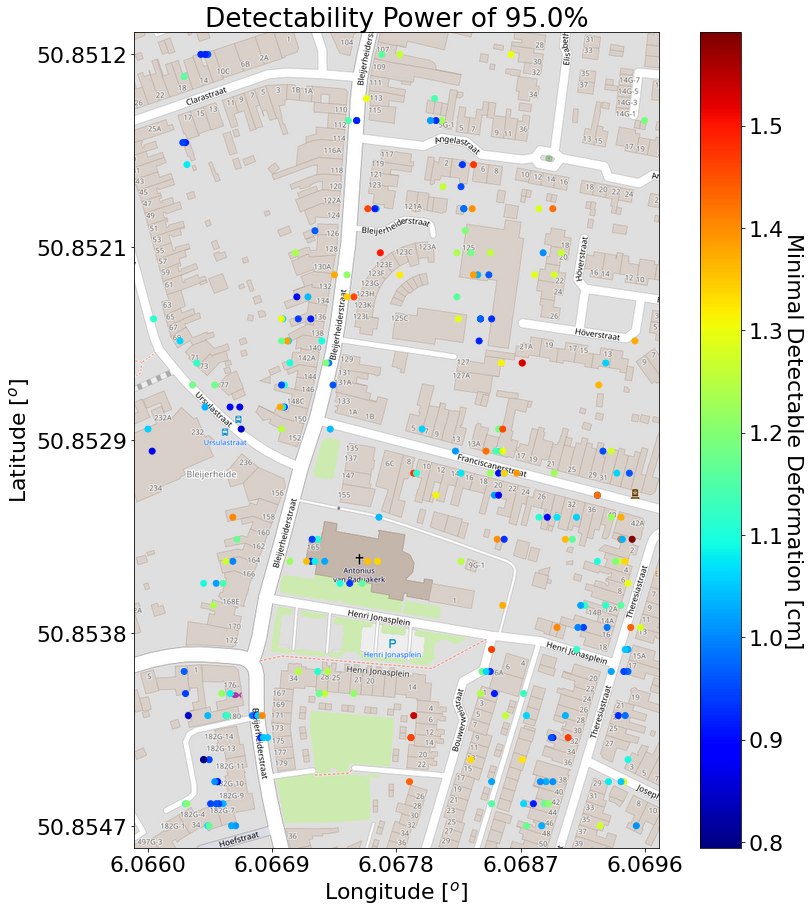

In [5]:
# Define the `extent`
plt.rcParams.update({'font.size': 22})
buffer = 0.0001
extent = tilemapbase.Extent.from_lonlat(min(data['pnt_lon'])-buffer,max(data['pnt_lon'])+buffer,
                                        min(data['pnt_lat'])-buffer,max(data['pnt_lat'])+buffer)

fig, ax = plt.subplots(figsize=(15,15))

plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=600)
plotter.plot(ax)

points = [tilemapbase.project(x,y) for x,y in zip(data['pnt_lon'],data['pnt_lat'])]
lon,lat = zip(*points)

p = ax.scatter(lon, lat, c=MDD,cmap='jet')
clb = plt.colorbar(p)
clb.set_label("Minimal Detectable Deformation [cm]",rotation=270,labelpad=20)

ax.set_title(f'Detectability Power of {decpow*100}%')
ax.set_xlabel('Longitude [$^o$]')
ax.set_ylabel('Latitude [$^o$]');

#remove tilemapbase axes labels with own labels
x_axes = np.linspace(min(lon),max(lon),5)
x_axes_real = np.linspace(min(data['pnt_lon']),max(data['pnt_lon']),5)
y_axes = np.linspace(min(lat),max(lat),5)
y_axes_real = np.linspace(min(data['pnt_lat']),max(data['pnt_lat']),5)
plt.setp(ax, xticks=x_axes, xticklabels=['{:.04f}'.format(l) for l in x_axes_real],
        yticks=y_axes,yticklabels=['{:.04f}'.format(l) for l in y_axes_real])

# fig.savefig('detectability_Map.eps',format='eps')
# fig.savefig('detectability_Map.jpg',format='jpg');

In [6]:
MDD = []
decpow = 0.60

for item in sigma_lin_model:
    input_var = [item,decpow]
    MDD.append(100*scipy.optimize.fsolve(function2,item,input_var))

mdd_list = []

for item in MDD:
    mdd_list.append(item[0])

(array([ 8., 42., 43., 44., 33., 31., 22., 21., 13.,  3.]),
 array([0.34111074, 0.37531801, 0.40952527, 0.44373254, 0.4779398 ,
        0.51214707, 0.54635434, 0.5805616 , 0.61476887, 0.64897613,
        0.6831834 ]),
 <BarContainer object of 10 artists>)

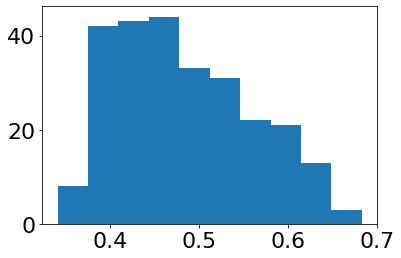

In [7]:
plt.figure()
plt.hist(mdd_list)

In [8]:
dec_pow = []
m1 = 0
m2 = 0.012 # 1.2cm

for item in sigma_lin_model:
    result = solve(m1,m2,item,item)
    r = result[0]
    area = 1-(norm.cdf(r,m2,item) + (1-norm.cdf(r,m1,item)))
    dec_pow.append(area*100)

 Text(0.5168501111111111, 0, '6.0660'),
 Text(0.5168525902777779, 0, '6.0669'),
 Text(0.5168550694444445, 0, '6.0678'),
 Text(0.5168575486111111, 0, '6.0687'),
 Text(0.5168600277777778, 0, '6.0696'),
 Text(0, 0.33541786095209364, '50.8512'),
 Text(0, 0.335421710953711, '50.8521'),
 Text(0, 0.3354255609553284, '50.8529'),
 Text(0, 0.33542941095694573, '50.8538'),
 Text(0, 0.3354332609585631, '50.8547')]

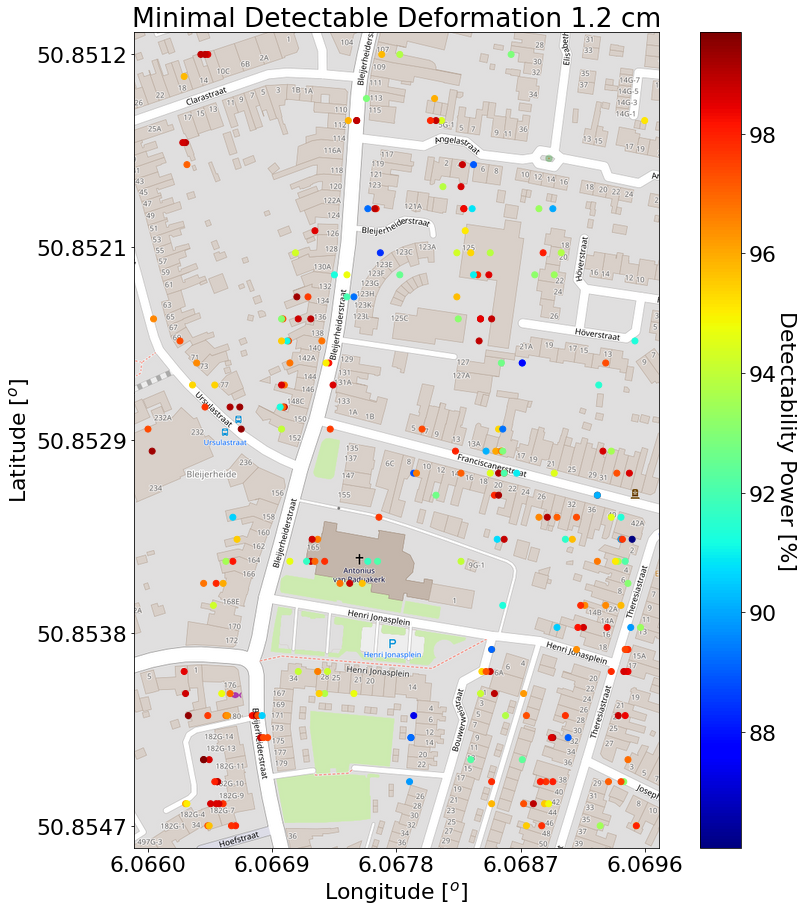

In [9]:
# Define the `extent`
buffer = 0.0001
extent = tilemapbase.Extent.from_lonlat(min(data['pnt_lon'])-buffer,max(data['pnt_lon'])+buffer,
                                        min(data['pnt_lat'])-buffer,max(data['pnt_lat'])+buffer)

fig, ax = plt.subplots(figsize=(15,15))

plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=600)
plotter.plot(ax)

points = [tilemapbase.project(x,y) for x,y in zip(data['pnt_lon'],data['pnt_lat'])]
lon,lat = zip(*points)

p = ax.scatter(lon, lat, c=dec_pow,cmap='jet')
clb = plt.colorbar(p)
clb.set_label("Detectability Power [%]",rotation=270,labelpad=20)

ax.set_title(f'Minimal Detectable Deformation {m2*100} cm')
ax.set_xlabel('Longitude [$^o$]')
ax.set_ylabel('Latitude [$^o$]');

#remove tilemapbase axes labels with own labels
x_axes = np.linspace(min(lon),max(lon),5)
x_axes_real = np.linspace(min(data['pnt_lon']),max(data['pnt_lon']),5)
y_axes = np.linspace(min(lat),max(lat),5)
y_axes_real = np.linspace(min(data['pnt_lat']),max(data['pnt_lat']),5)
plt.setp(ax, xticks=x_axes, xticklabels=['{:.04f}'.format(l) for l in x_axes_real],
        yticks=y_axes,yticklabels=['{:.04f}'.format(l) for l in y_axes_real])

# fig.savefig('detectability_Map_MDD.eps',format='eps')
# fig.savefig('detectability_Map_MDD.jpg',format='jpg')

# Making the graph for statistics on the amount of mdd and dp in the subset

In [17]:
MDD

array([[27.2567125 , 27.2567125 , 27.2567125 , ..., 27.2567125 ,
        27.2567125 , 27.2567125 ],
       [35.19563333, 35.19563333, 35.19563333, ..., 35.19563333,
        35.19563333, 35.19563333],
       [26.82498812, 26.82498812, 26.82498812, ..., 26.82498812,
        26.82498812, 26.82498812],
       ...,
       [27.99867374, 27.99867374, 27.99867374, ..., 27.99867374,
        27.99867374, 27.99867374],
       [31.32369469, 31.32369469, 31.32369469, ..., 31.32369469,
        31.32369469, 31.32369469],
       [24.23680359, 24.23680359, 24.23680359, ..., 24.23680359,
        24.23680359, 24.23680359]])

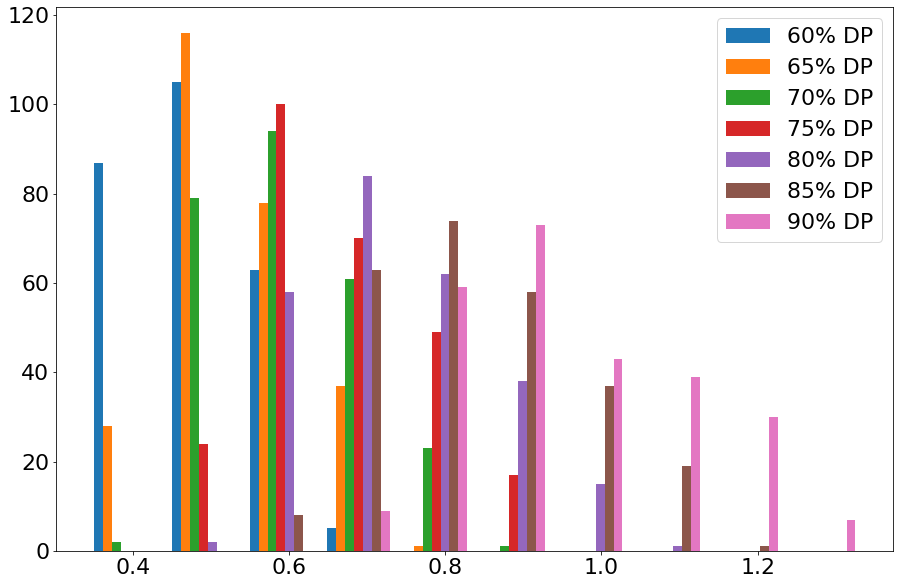

In [28]:
dp_range = np.arange(0.60,0.95,0.05)
a,b,sigma_lin_model = linear_model(get_sentinel_days(list(data)),data)
array_len = len(sigma_lin_model)

plt.figure(figsize=(15,10))

MDD = np.zeros((array_len,len(dp_range)))

for ii,dp_value in enumerate(dp_range):

    for i,item in enumerate(sigma_lin_model):
        input_var = [item,dp_value]
        
        MDD_out = 100*scipy.optimize.fsolve(function2,item,input_var)
        
#         MDD.append(MDD_out[0])
        MDD[i,ii] = MDD_out
#     plt.scatter([dp_value for _ in range(array_len)],MDD)
plt.hist(MDD,label=["{:.0f}% DP".format(100*x) for x in dp_range])
plt.legend();

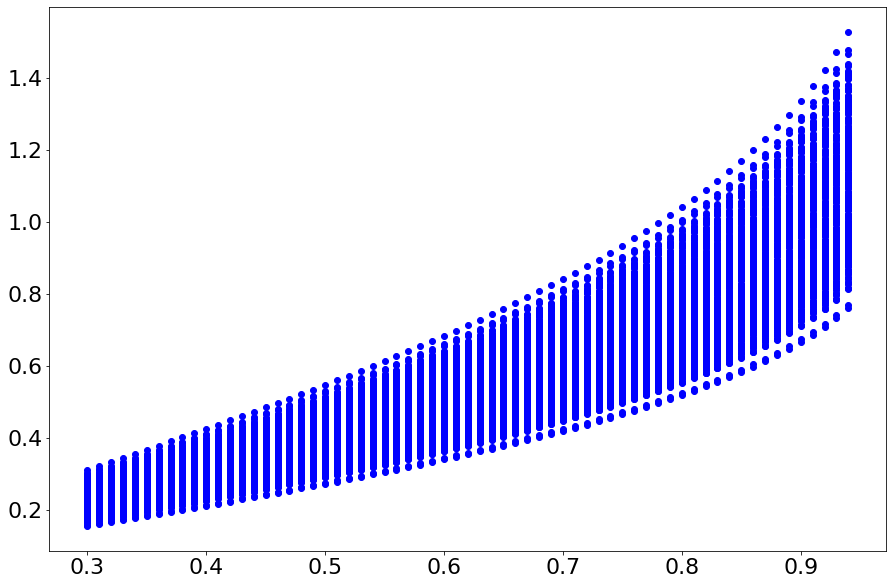

In [25]:
dp_range = np.arange(0.30,0.95,0.01)

plt.figure(figsize=(15,10))

# MDD = np.zeros((array_len,len(dp_range)))

for ii,dp_value in enumerate(dp_range):
    MDD = []
    for i,item in enumerate(sigma_lin_model):
        input_var = [item,dp_value]
        
        MDD_out = 100*scipy.optimize.fsolve(function2,item,input_var)
        
        MDD.append(MDD_out[0])
#         MDD[i,ii] = MDD_out
    plt.scatter([dp_value for _ in range(array_len)],MDD,c='b')